# Perceptron

# 1. Stochastic Gradient Descent

In [1]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Data Preperation
train_data = pd.read_csv("Diabetes/Train.csv")
test_data = pd.read_csv("Diabetes/Test.csv")
train_data = train_data[train_data["BMI"] != 0]
train_data = train_data[train_data["Glucose"] != 0]
train_data = train_data[train_data["BloodPressure"] != 0]
train_data["Outcome"].replace([True, False], [1, -1], inplace=True)
train_data = train_data.reset_index(drop=True)
# Min-Max Scaler (Normalization)
headers = train_data.columns.to_list()
attrs = headers[:-1]
for attr in attrs:
    col_min = train_data[attr].min()
    col_max = train_data[attr].max()
    train_data[attr] = (train_data[attr] - col_min) / (col_max - col_min)
train_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000
mean,0.224017,0.500630,0.493691,0.219850,0.098288,0.288580,0.176751,0.202763,-0.316062
std,0.199791,0.196790,0.125150,0.157958,0.135714,0.138541,0.142697,0.200166,0.949559
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.058824,0.358065,0.408163,0.000000,0.000000,0.189162,0.076697,0.050000,-1.000000
50%,0.176471,0.470968,0.489796,0.242424,0.056738,0.284254,0.134389,0.133333,-1.000000
75%,0.352941,0.619355,0.571429,0.333333,0.153664,0.373211,0.243891,0.325000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 0, 'Iteration')

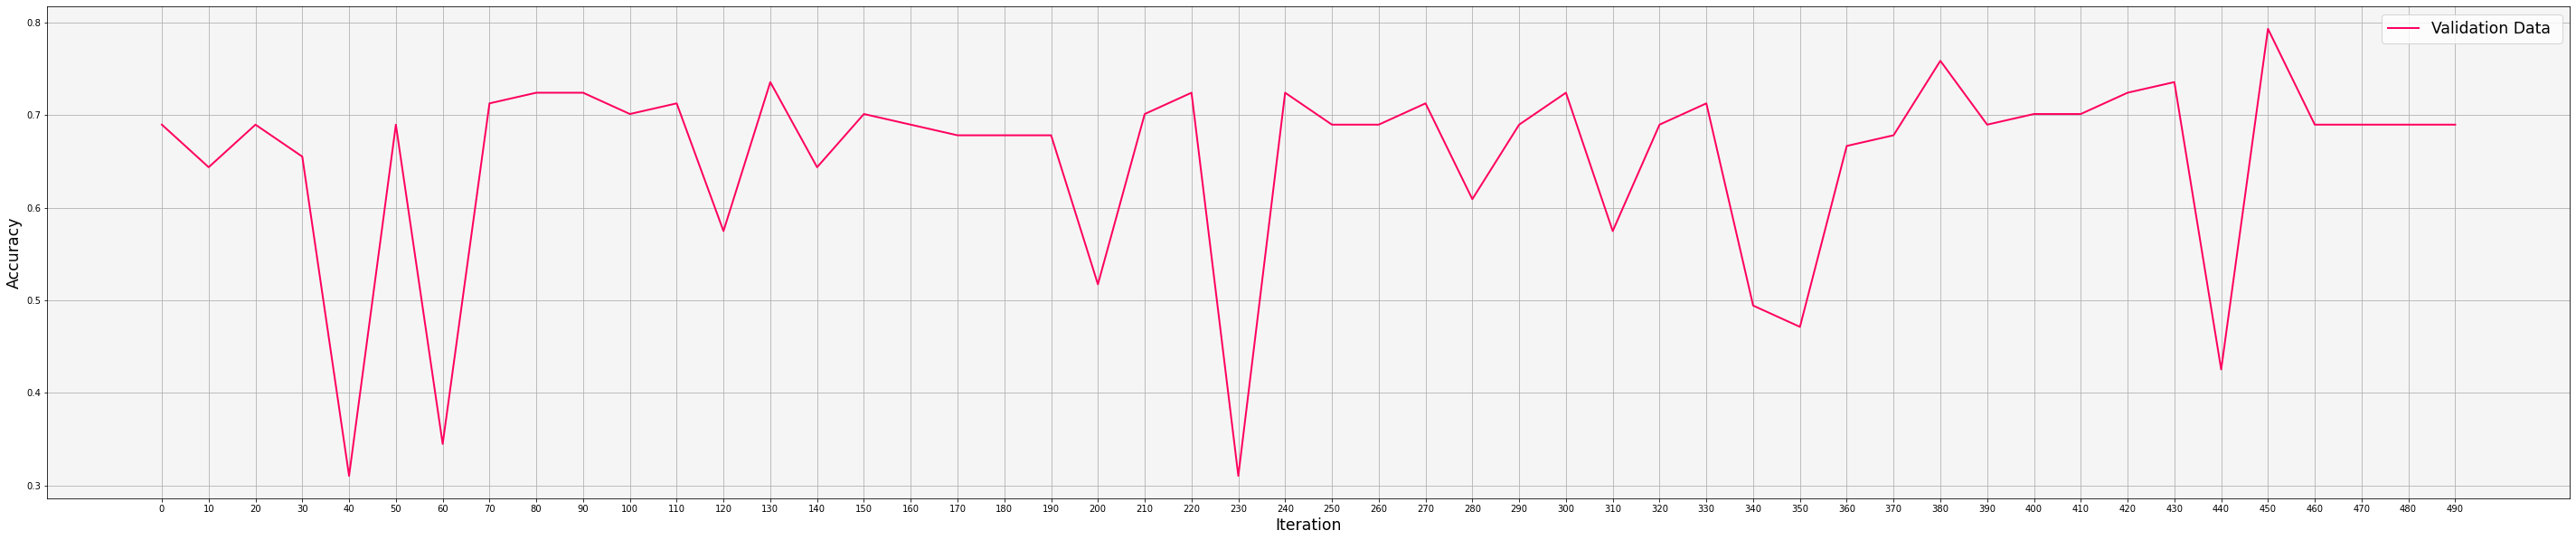

In [2]:
# Train Validation Split
valid_data = train_data.sample(frac=0.15, random_state=42)
valid_indices = valid_data.index.to_list()
train_data.drop(index=valid_indices, inplace=True)
train_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)

train_expect = train_data["Outcome"]
train_feature = train_data.drop(labels="Outcome", axis=1)
train_feature.insert(0, "Ones", 1)
valid_expect = valid_data["Outcome"]
valid_feature = valid_data.drop(labels="Outcome", axis=1)
valid_feature.insert(0, "Ones", 1)

def accuracy(predict, outcome):
    correct = predict == outcome
    return correct.sum()/outcome.size


def predict(x, w):
    return np.sign(x@w)[0]


def fit(train_feature, train_expect, n_iteration=100, learning_rate=0.01):
    iter_weights = {}
    d = train_feature.iloc[0].shape[0]
    w = np.zeros((d, 1))
    n = train_feature.shape[0]
    for t in range(n_iteration):
        i = t % n
        x = train_feature.iloc[i]
        y = train_expect.iloc[i]
        y_hat = predict(x, w)
        if y_hat != y:
            w = w + learning_rate*x.values.reshape((x.size, 1))*y
        iter_weights[str(t)] = w
    return iter_weights


iter_weights = fit(train_feature, train_expect, n_iteration=500)

def evaluate(valid_feature, valid_expect, iter_weights):
    iter_acc = {}
    max_accr, best_weight = 0, None
    for iteration, weight in iter_weights.items():
        accr = accuracy(predict(valid_feature, weight), valid_expect)
        if int(iteration) % 10 == 0:
            iter_acc[iteration] = accr
        if accr > max_accr:
            max_accr = accr
            best_weight = weight
    return iter_acc, best_weight, max_accr

iter_acc, weight, max_accr = evaluate(valid_feature, valid_expect, iter_weights)

fig, ax = plt.subplots(figsize=(50, 10))
ax.plot(iter_acc.keys(), iter_acc.values(),
        label="Validation Data ", color="#FF005E", linewidth=2)
ax.grid(True)
ax.legend(fontsize="xx-large")
ax.set_facecolor('#f5f5f5')
ax.set_ylabel("Accuracy", fontsize="xx-large")
ax.set_xlabel("Iteration", fontsize="xx-large")

In [3]:
#Test Data Preperation
test_data = test_data[test_data["BMI"] != 0]
test_data = test_data[test_data["Glucose"] != 0]
test_data = test_data[test_data["BloodPressure"] != 0]
test_data["Outcome"].replace([True, False], [1, -1], inplace=True)
test_data = test_data.reset_index(drop=True)
for attr in attrs:
    col_min = test_data[attr].min()
    col_max = test_data[attr].max()
    test_data[attr] = (test_data[attr] - col_min) / (col_max - col_min)
test_expect = test_data["Outcome"]
test_feature = test_data.drop(labels="Outcome", axis=1)
test_feature.insert(0, "Ones", 1)
predicts = predict(test_feature, weight)
#Precision = TP/(TP+FP)
correct = predicts == test_expect
tp = predicts[correct] == 1
tp = tp.sum()
tp_fp = predicts == 1
tp_fp = tp_fp.sum()
precision = tp/tp_fp
print("Precision:", precision)
#Recall = TP/(TP+FN)
wrong = predicts != test_expect
fn = predicts[wrong]
fn = fn == -1
fn = fn.sum()
tp_fn = tp+fn
recall = tp/tp_fn
print("Recall:", recall)
#F-Score
f_score = 2*precision*recall/(precision+recall)
print("f_score:", f_score)
# Sensitivity equals to Recall
sensitivity = recall
print("Sensitivity:", sensitivity)
#Specificity = TN/(TN+FP)
neg = predicts == -1
neg = neg.sum()
tn = neg - fn
pos = predicts == 1
pos = pos.sum()
fp = pos - tp
tn_fp = tn+fp
specificity = tn/(tn_fp)
print("Specificity:", specificity)


Precision: 0.7021276595744681
Recall: 0.6470588235294118
f_score: 0.673469387755102
Sensitivity: 0.6470588235294118
Specificity: 0.851063829787234


# 2. Batch Gradient Descent

In [4]:
#Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Data Preperation
train_data = pd.read_csv("Diabetes/Train.csv")
test_data = pd.read_csv("Diabetes/Test.csv")
train_data = train_data[train_data["BMI"] != 0]
train_data = train_data[train_data["Glucose"] != 0]
train_data = train_data[train_data["BloodPressure"] != 0]
test_data = test_data[test_data["BMI"] != 0]
test_data = test_data[test_data["Glucose"] != 0]
test_data = test_data[test_data["BloodPressure"] != 0]
train_data["Outcome"].replace([True, False], [1, -1], inplace=True)
train_data = train_data.reset_index(drop=True)
test_data["Outcome"].replace([True, False], [1, -1], inplace=True)
test_data = test_data.reset_index(drop=True)
#Min-Max Scaler (Normalization)
headers = train_data.columns.to_list()
attrs = headers[:-1]
for attr in attrs:
    col_min = train_data[attr].min()
    col_max = train_data[attr].max()
    train_data[attr] = (train_data[attr] - col_min) / (col_max - col_min)
for attr in attrs:
    col_min = test_data[attr].min()
    col_max = test_data[attr].max()
    test_data[attr] = (test_data[attr] - col_min) / (col_max - col_min)
train_data.describe()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000
mean,0.224017,0.500630,0.493691,0.219850,0.098288,0.288580,0.176751,0.202763,-0.316062
std,0.199791,0.196790,0.125150,0.157958,0.135714,0.138541,0.142697,0.200166,0.949559
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.058824,0.358065,0.408163,0.000000,0.000000,0.189162,0.076697,0.050000,-1.000000
50%,0.176471,0.470968,0.489796,0.242424,0.056738,0.284254,0.134389,0.133333,-1.000000
75%,0.352941,0.619355,0.571429,0.333333,0.153664,0.373211,0.243891,0.325000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
#Train Validation Split
valid_data = train_data.sample(frac=0.15, random_state=42)
valid_indices = valid_data.index.to_list()
train_data.drop(index=valid_indices, inplace=True)
train_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)
train_expect = train_data["Outcome"]
train_feature = train_data[attrs]
train_feature.insert(0, "Ones", 1)


In [6]:
def predict(x, w):
    return np.sign(x@w)[0]

In [7]:
#Full Batch
def fit(feature, expect, n_epoch=10, learning_rate=0.01):
    epoch_weight = {}
    d = feature.shape[1]
    w = np.random.random((d, 1))
    for epoch in range(1, n_epoch+1):
        x = feature
        y = expect
        y_hat = predict(x, w)
        wrong = y_hat != y
        x = x[wrong]
        y = y[wrong]
        w = w + (learning_rate*x.T@y).values.reshape((d, 1))
        epoch_weight[str(epoch)] = w
    return epoch_weight
        
epoch_weights = fit(train_feature, train_expect, n_epoch=20)
train_feature

,Ones,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1,0.058824,0.774194,0.591837,0.434343,0.079196,0.298569,0.119005,0.483333
1,1,0.058824,0.606452,0.591837,0.000000,0.000000,0.447853,0.071493,0.116667
2,1,0.117647,0.316129,0.408163,0.323232,0.189125,0.404908,0.269683,0.033333
3,1,0.058824,0.367742,0.265306,0.151515,0.042553,0.122699,0.202715,0.083333
4,1,0.117647,0.438710,0.520408,0.323232,0.000000,0.357873,0.031674,0.000000
...,...,...,...,...,...,...,...,...,...
487,1,0.117647,0.541935,0.551020,0.373737,0.215130,0.513292,0.518552,0.166667
488,1,0.058824,0.961290,0.265306,0.161616,0.443262,0.157464,0.261086,0.050000
489,1,0.058824,0.361290,0.428571,0.151515,0.066194,0.110429,0.266063,0.083333
490,1,0.294118,0.638710,0.551020,0.000000,0.000000,0.548057,0.050679,0.433333


Text(0.5, 0, 'Epoch')

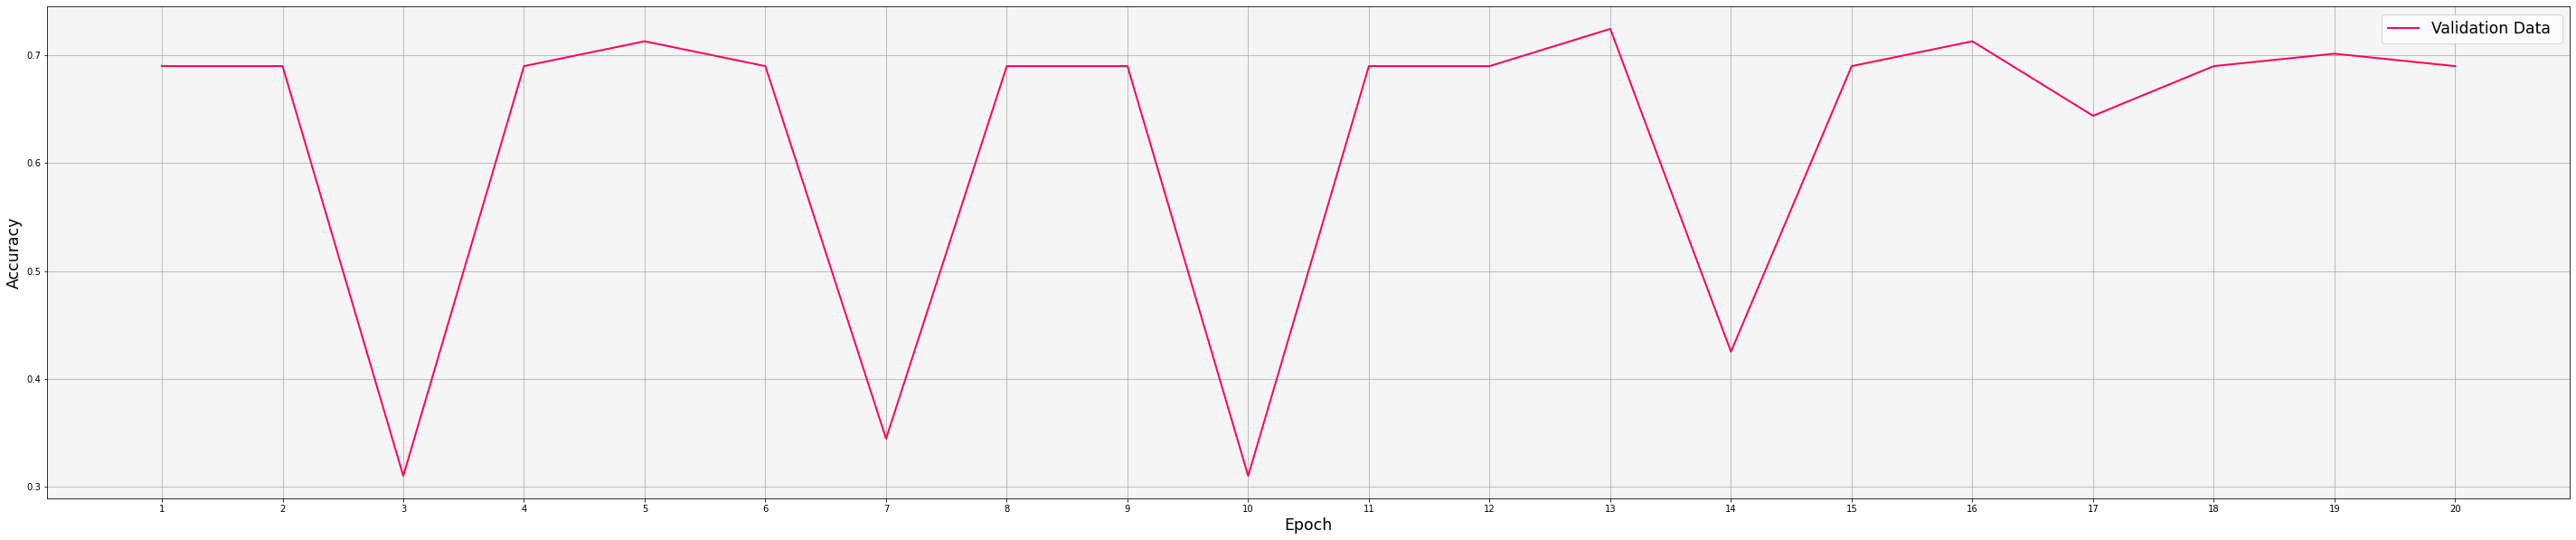

In [8]:
def accuracy(predict, outcome):
    correct = predict == outcome
    return correct.sum()/outcome.size

def evaluate(valid_feature, valid_expect, epoch_weights):
    epoch_acc = {}
    max_accr, best_weight = 0, None
    for epoch, weight in epoch_weights.items():
        accr = accuracy(predict(valid_feature, weight), valid_expect)
        epoch_acc[epoch] = accr
        if accr > max_accr:
            max_accr = accr
            best_weight = weight
    return epoch_acc, best_weight, max_accr

valid_expect = valid_data["Outcome"]
valid_feature = valid_data.drop(labels="Outcome", axis=1)
valid_feature.insert(0, "Ones", 1)
 
epoch_acc, best_weight, max_accr = evaluate(valid_feature, valid_expect, epoch_weights)

fig, ax= plt.subplots(figsize=(50, 10))
ax.plot(epoch_acc.keys(), epoch_acc.values(), label="Validation Data ", color="#FF005E", linewidth=2)
ax.grid(True)
ax.legend(fontsize="xx-large")
ax.set_facecolor('#f5f5f5')
ax.set_ylabel("Accuracy", fontsize="xx-large")
ax.set_xlabel("Epoch", fontsize="xx-large")

In [9]:
test_expect = test_data["Outcome"]
test_feature = test_data.drop(labels="Outcome", axis = 1)
test_feature.insert(0, "Ones", 1)
predicts = predict(test_feature, best_weight)


In [10]:
#Precision = TP/(TP+FP)
correct = predicts == test_expect
tp = predicts[correct] == 1
tp = tp.sum()
tp_fp = predicts == 1
tp_fp = tp_fp.sum()
precision = tp/tp_fp
print("Precision:", precision)


Precision: 0.5581395348837209


In [11]:
#Recall = TP/(TP+FN)
wrong = predicts != test_expect
fn = predicts[wrong]
fn = fn == -1
fn = fn.sum()
tp_fn = tp+fn
recall = tp/tp_fn
print("Recall:", recall)

Recall: 0.47058823529411764


In [12]:
f_score = 2*precision*recall/(precision+recall)
print("f_score:", f_score)

f_score: 0.5106382978723404


In [13]:
#Sensitivity equals to Recall
sensitivity = recall
print("Sensitivity:", sensitivity)

Sensitivity: 0.47058823529411764


In [14]:
#Specificity = TN/(TN+FP)
neg = predicts == -1
neg = neg.sum()
tn = neg - fn
pos = predicts == 1
pos = pos.sum()
fp = pos - tp
tn_fp = tn+fp
specificity = tn/(tn_fp)
print("Specificity:", specificity)

Specificity: 0.7978723404255319


# 3. Mini Batch

In [15]:
#Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Data Preperation
train_data = pd.read_csv("Diabetes/Train.csv")
test_data = pd.read_csv("Diabetes/Test.csv")
train_data = train_data[train_data["BMI"] != 0]
train_data = train_data[train_data["Glucose"] != 0]
train_data = train_data[train_data["BloodPressure"] != 0]
test_data = test_data[test_data["BMI"] != 0]
test_data = test_data[test_data["Glucose"] != 0]
test_data = test_data[test_data["BloodPressure"] != 0]
train_data["Outcome"].replace([True, False], [1, -1], inplace=True)
train_data = train_data.reset_index(drop=True)
test_data["Outcome"].replace([True, False], [1, -1], inplace=True)
test_data = test_data.reset_index(drop=True)
#Min-Max Scaler (Normalization)
headers = train_data.columns.to_list()
attrs = headers[:-1]
for attr in attrs:
    col_min = train_data[attr].min()
    col_max = train_data[attr].max()
    train_data[attr] = (train_data[attr] - col_min) / (col_max - col_min)
for attr in attrs:
    col_min = test_data[attr].min()
    col_max = test_data[attr].max()
    test_data[attr] = (test_data[attr] - col_min) / (col_max - col_min)
train_data.describe()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000
mean,0.224017,0.500630,0.493691,0.219850,0.098288,0.288580,0.176751,0.202763,-0.316062
std,0.199791,0.196790,0.125150,0.157958,0.135714,0.138541,0.142697,0.200166,0.949559
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.058824,0.358065,0.408163,0.000000,0.000000,0.189162,0.076697,0.050000,-1.000000
50%,0.176471,0.470968,0.489796,0.242424,0.056738,0.284254,0.134389,0.133333,-1.000000
75%,0.352941,0.619355,0.571429,0.333333,0.153664,0.373211,0.243891,0.325000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
#Train Validation Split
valid_data = train_data.sample(frac=0.15, random_state=42)
valid_indices = valid_data.index.to_list()
train_data.drop(index=valid_indices, inplace=True)
train_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)
train_expect = train_data["Outcome"]
train_feature = train_data[attrs]
train_feature.insert(0, "Ones", 1)


In [17]:
def predict(x, w):
    return np.sign(x@w)[0]

#Mini Batch
def fit(feature, expect, n_epoch=10, learning_rate=0.01, n_batch=5):
    batch = 1
    batch_weight = {}
    d = feature.shape[1]
    w = np.random.random((d, 1))
    n = train_feature.shape[0]
    indices = np.linspace(0, n, num= n_batch+1, dtype=np.int32)
    for epoch in range(1, n_epoch+1):
        random_state = np.random.randint(51)
        feature = feature.sample(frac=1, random_state=random_state)
        expect = expect.sample(frac=1, random_state=random_state)
        for idx in range(len(indices)-1):
            x = feature.iloc[indices[idx]:indices[idx+1]]
            y = expect.iloc[indices[idx]:indices[idx+1]]
        y_hat = predict(x, w)
        wrong = y_hat != y
        x = x[wrong]
        y = y[wrong]
        w = w + (learning_rate*x.T@y).values.reshape((d, 1))
        batch_weight[str(batch)] = w
        batch += 1
    return batch_weight
        
batch_weights = fit(train_feature, train_expect, n_epoch=20)


Text(0.5, 0, 'Batch')

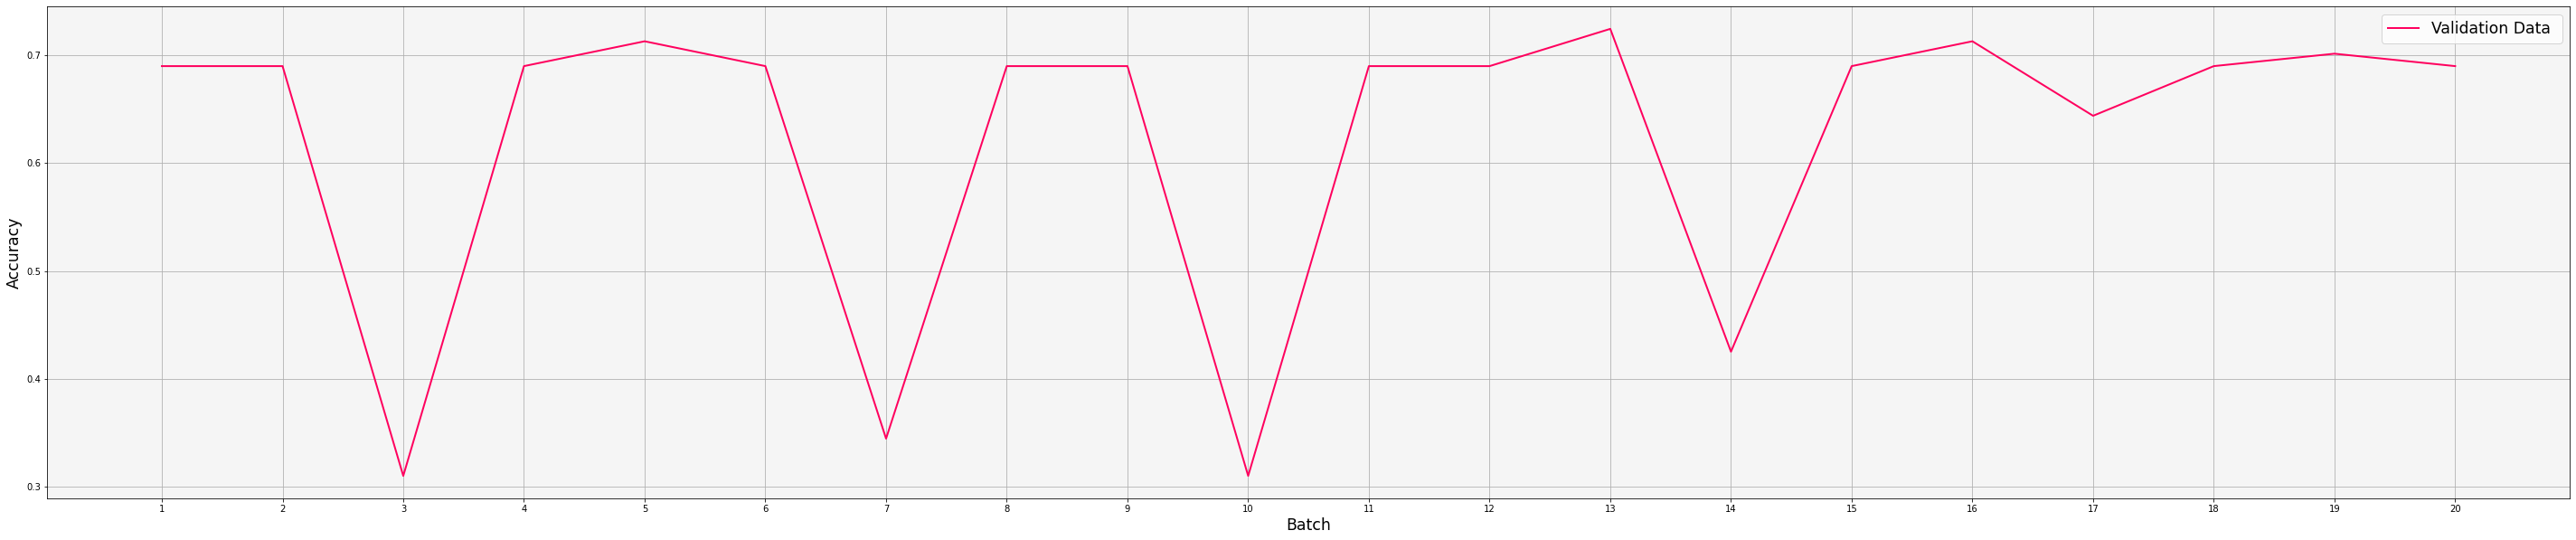

In [18]:
def accuracy(predict, outcome):
    correct = predict == outcome
    return correct.sum()/outcome.size

def evaluate(valid_feature, valid_expect, batch_weights):
    batch_acc = {}
    max_accr, best_weight = 0, None
    for batch, weight in epoch_weights.items():
        accr = accuracy(predict(valid_feature, weight), valid_expect)
        batch_acc[batch] = accr
        if accr > max_accr:
            max_accr = accr
            best_weight = weight
    return batch_acc, best_weight, max_accr

valid_expect = valid_data["Outcome"]
valid_feature = valid_data.drop(labels="Outcome", axis=1)
valid_feature.insert(0, "Ones", 1)
 
batch_acc, best_weight, max_accr = evaluate(valid_feature, valid_expect, epoch_weights)

fig, ax= plt.subplots(figsize=(50, 10))
ax.plot(batch_acc.keys(), batch_acc.values(), label="Validation Data ", color="#FF005E", linewidth=2)
ax.grid(True)
ax.legend(fontsize="xx-large")
ax.set_facecolor('#f5f5f5')
ax.set_ylabel("Accuracy", fontsize="xx-large")
ax.set_xlabel("Batch", fontsize="xx-large")

In [19]:
test_expect = test_data["Outcome"]
test_feature = test_data.drop(labels="Outcome", axis = 1)
test_feature.insert(0, "Ones", 1)
predicts = predict(test_feature, best_weight)


In [20]:
#Precision = TP/(TP+FP)
correct = predicts == test_expect
tp = predicts[correct] == 1
tp = tp.sum()
tp_fp = predicts == 1
tp_fp = tp_fp.sum()
precision = tp/tp_fp
print("Precision:", precision)


Precision: 0.5581395348837209


In [21]:
#Recall = TP/(TP+FN)
wrong = predicts != test_expect
fn = predicts[wrong]
fn = fn == -1
fn = fn.sum()
tp_fn = tp+fn
recall = tp/tp_fn
print("Recall:", recall)

Recall: 0.47058823529411764


In [22]:
f_score = 2*precision*recall/(precision+recall)
print("f_score:", f_score)

f_score: 0.5106382978723404


In [23]:
#Sensitivity equals to Recall
sensitivity = recall
print("Sensitivity:", sensitivity)

Sensitivity: 0.47058823529411764


In [24]:
#Specificity = TN/(TN+FP)
neg = predicts == -1
neg = neg.sum()
tn = neg - fn
pos = predicts == 1
pos = pos.sum()
fp = pos - tp
tn_fp = tn+fp
specificity = tn/(tn_fp)
print("Specificity:", specificity)

Specificity: 0.7978723404255319
